# Traffic Intelligence: Enhancing Urban Mobility

## Table Of Contents
    
<ol>
    <li>Importing Libraries</li>
    <li>Loading Data</li>
    <li>Data Exploration</li>
    <li>Feature Engineering</li>
    <li>Data Transformation And Preprocessing</li>
    <li>Model Building</li>
    <li>Fitting The Model</li>
    <li>Summary<br><br></li>
</ol>

## 1. Importing Libraries

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import warnings
warnings.filterwarnings("ignore")

## 2. Loading Data

In [25]:
dataset = pd.read_csv("traffic.csv")
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


**About the data**

This dataset is a collection of numbers of vehicles at four junctions at an hourly frequency. 
The CSV file provides four features:

* DateTime
* Junctions
* Vehicles
* ID

The sensors on each of these junctions were collecting data at different times, hence the traffic data from different time periods. Some of the junctions have provided limited or sparse data.

In [26]:
data = dataset.copy()

## 3. Data Exploration

In [27]:
df["DateTime"]= pd.to_datetime(dataset["DateTime"])
dataset = dataset.drop(["ID"], axis=1) #dropping IDs
dataset.info

<bound method DataFrame.info of                  DateTime  Junction  Vehicles
0     2015-11-01 00:00:00         1        15
1     2015-11-01 01:00:00         1        13
2     2015-11-01 02:00:00         1        10
3     2015-11-01 03:00:00         1         7
4     2015-11-01 04:00:00         1         9
...                   ...       ...       ...
48115 2017-06-30 19:00:00         4        11
48116 2017-06-30 20:00:00         4        30
48117 2017-06-30 21:00:00         4        16
48118 2017-06-30 22:00:00         4        22
48119 2017-06-30 23:00:00         4        12

[48120 rows x 3 columns]>

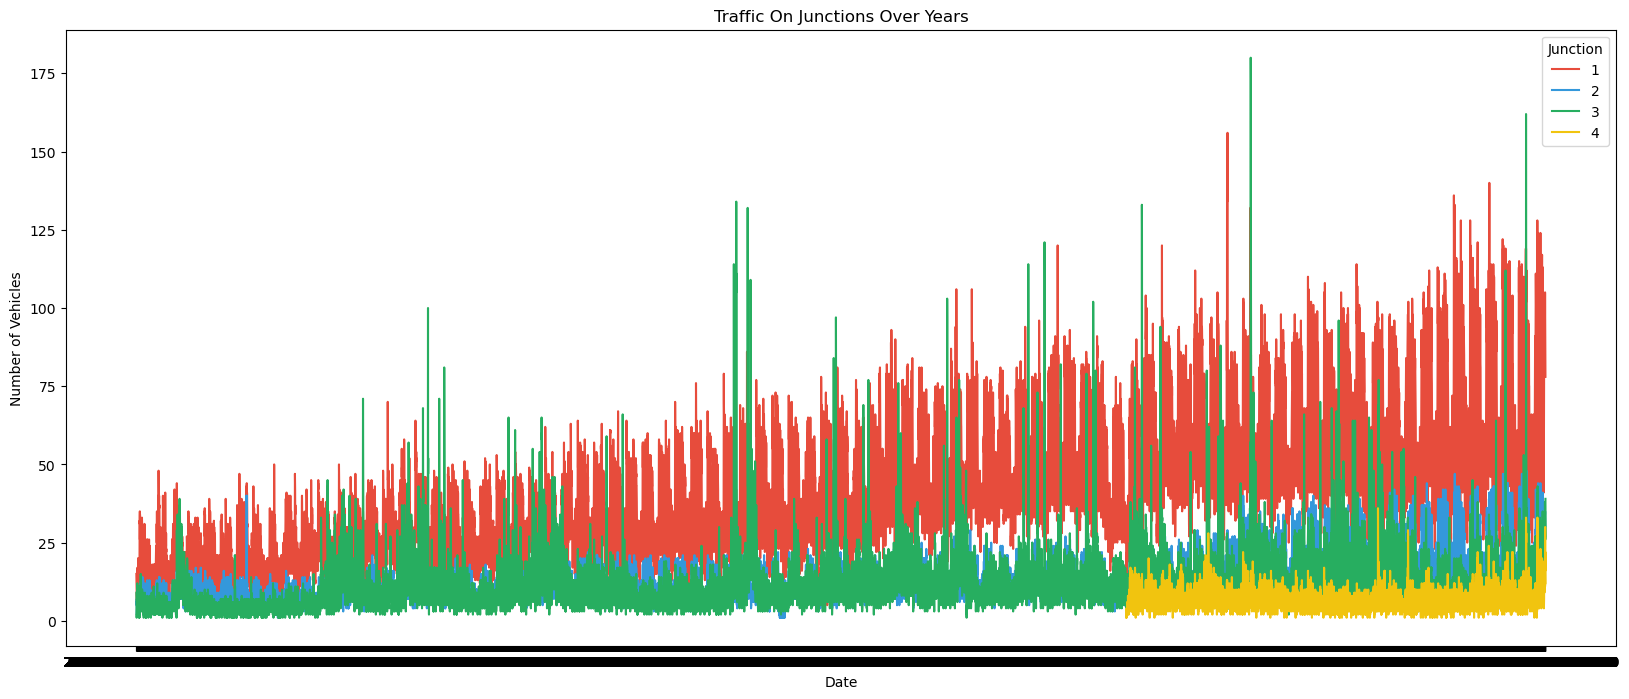

In [28]:
df=data.copy() 
new_colors = ["#E74C3C", "#3498DB", "#27AE60", "#F1C40F"]

plt.figure(figsize=(20, 8))
Time_series = sns.lineplot(x=df['DateTime'], y="Vehicles", data=df, hue="Junction", palette=new_colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

# Show the plot
plt.show()

##**Insights:**

* It can be seen here that the first junction is visibly having an upward trend.
* The data for the fourth junction is sparse starting only after 2017
* Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it. 

## 4. Feature Engineering

At this step, I am creating a few new features out of DateTime. 
Namely:
* Year
* Month 
* Date in the given month
* Days of week 
* Hour

In [85]:
#Pivoting data fron junction 
df_J = df.pivot(columns="Junction", index="DateTime")
df_J["Vehicles"].describe()

Junction,1,2,3,4
count,14592.000000,14592.000000,14592.000000,4344.000000
mean,45.052906,14.253221,13.694010,7.251611
std,23.008345,7.401307,10.436005,3.521455
min,5.000000,1.000000,1.000000,1.000000
25%,27.000000,9.000000,7.000000,5.000000
50%,40.000000,13.000000,11.000000,7.000000
75%,59.000000,17.000000,18.000000,9.000000
max,156.000000,48.000000,180.000000,36.000000


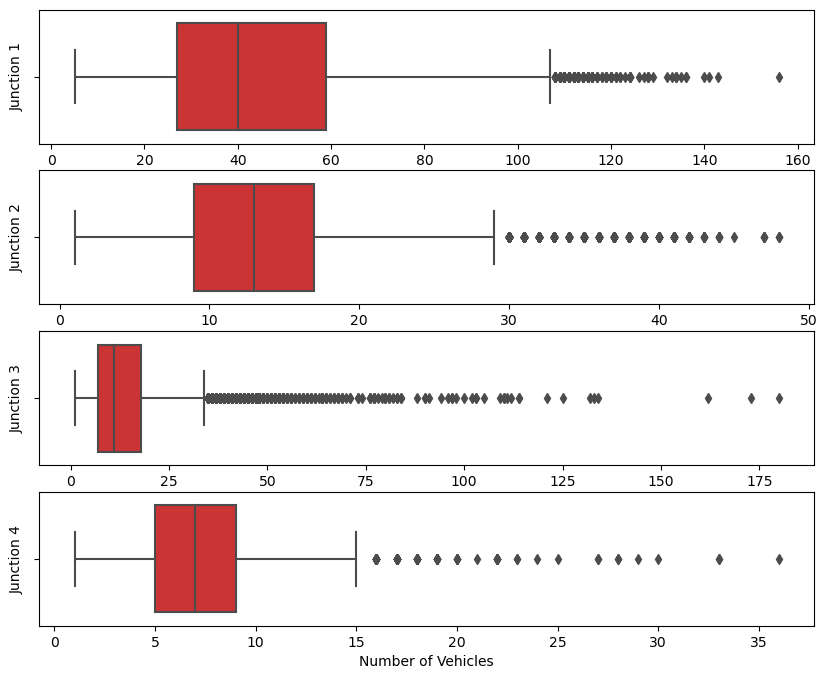

In [84]:
# Creating plot

fig, axes = plt.subplots(4, 1, figsize=(10, 8))
colors = sns.color_palette("Set1", n_colors=4)

for i in range(4):
    sns.boxplot(data=df[df["Junction"] == i + 1], x="Vehicles", palette=colors, ax=axes[i])
    axes[i].set_ylabel("Junction "+str(i+1))
    axes[i].set_xlabel("Number of Vehicles")

plt.show()
 

In [36]:
df["DateTime"]= pd.to_datetime(df["DateTime"])

df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday


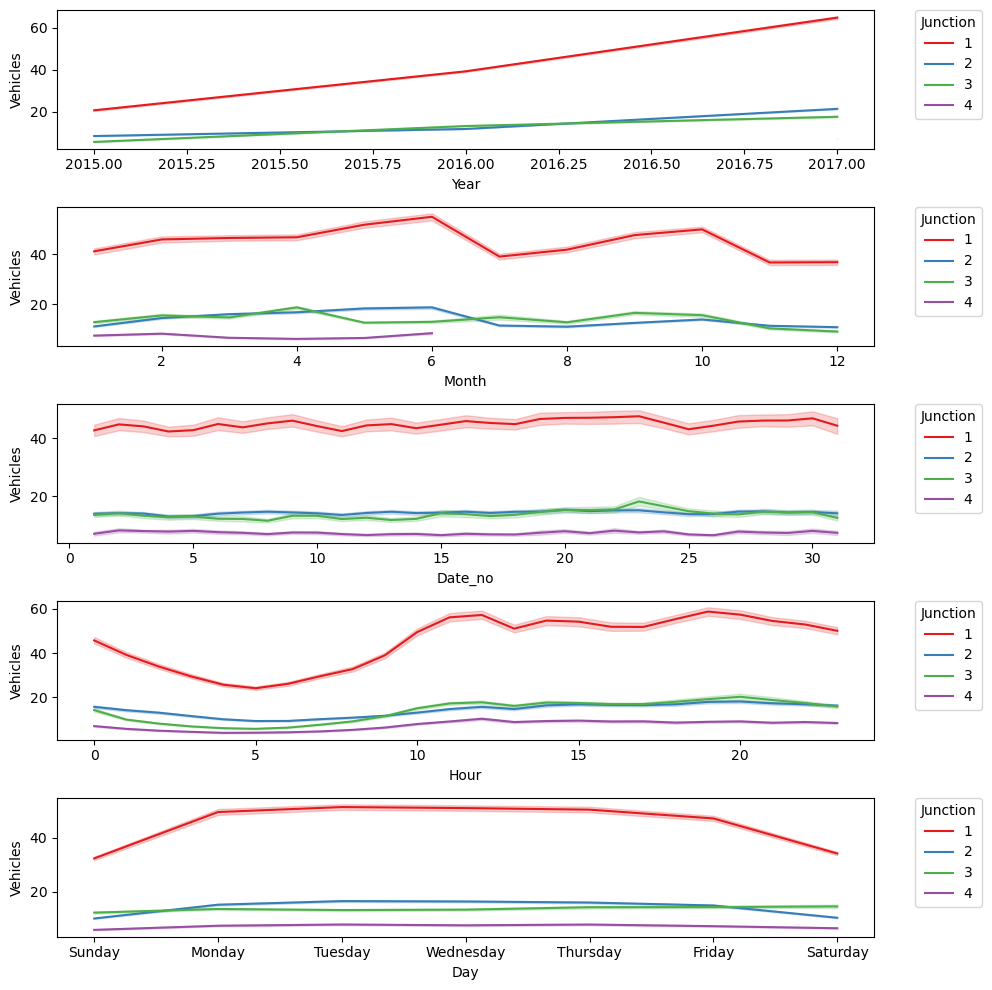

In [38]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]
colors = sns.color_palette("Set1", n_colors=len(new_features))

fig, axes = plt.subplots(len(new_features), 1, figsize=(10, 2 * len(new_features)))

for idx, feature in enumerate(new_features):
    sns.lineplot(x=df[feature], y="Vehicles", data=df, hue="Junction", palette=colors, ax=axes[idx])
    axes[idx].legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Junction", borderaxespad=0.)
    axes[idx].set_xlabel(feature)

plt.tight_layout()
plt.show()

**From the above plot following things can be concluded:**


<ul>
    <li style="color: rgb(14, 16, 26);"><span style="color: rgb(14, 16, 26);">There has been a consistent upward trend for all junctions except for the fourth one, which has limited data that doesn&apos;t span over a year.</span></li>
    <li style="color: rgb(14, 16, 26);"><span style="color: rgb(14, 16, 26);">During June, there is a noticeable increase in traffic at the first and second junctions, which may be attributed to summer break and related activities.&nbsp;</span></li>
    <li style="color: rgb(14, 16, 26);"><span style="color: rgb(14, 16, 26);">Monthly data shows good consistency across all dates.&nbsp;</span></li>
    <li style="color: rgb(14, 16, 26);"><span style="color: rgb(14, 16, 26);">Throughout a typical day, there are peaks in traffic during morning and evening hours and a decline during nighttime, as expected.&nbsp;</span></li>
    <li><span style="color: rgb(14, 16, 26);">On a weekly basis, traffic flows more smoothly on Sundays due to fewer vehicles on the roads. Conversely, traffic is steady from Monday to Friday.</span></li>
</ul>

Text(0.5, 0, 'Date')

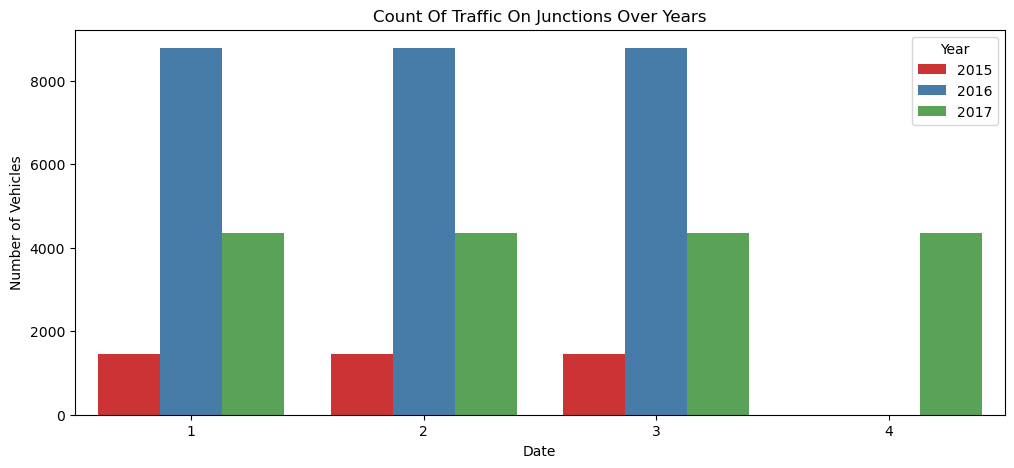

In [40]:
plt.figure(figsize=(12,5))
count = sns.countplot(data=df, x =df["Junction"], hue="Year", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

Based on the count plot, it is evident that the number of vehicles rose from 2015 to 2016. However, it is not possible to make a definitive conclusion regarding 2017 as we only have data up until the seventh month.

## 5. Data Transformation And Preprocessing

**In this step I will be following the subsequent order:**


<li>Creating different frames for each Junction and plotting them</li>
<li>Transforming the series and plotting them</li>
<li>Creating test and train sets</li>

In [88]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months
df_1.head()

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

# #Function to plot comparitive plots of dataframes
# def Sub_Plots4(df_1, df_2,df_3,df_4,title):
#     fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharey=True)
#     fig.suptitle(title)
#     #J1
#     pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
#     #pl_1=plt.ylabel()
#     axes[0].set(ylabel ="Junction 1")
#     #J2
#     pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
#     axes[1].set(ylabel ="Junction 2")
#     #J3
#     pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
#     axes[2].set(ylabel ="Junction 3")
#     #J4
#     pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
#     axes[3].set(ylabel ="Junction 4")
    
    
# #Plotting the dataframe to check for stationarity
# Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

**Steps for Transforming:**
* Normalizing 
* Differencing 

In [90]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:
* For Junction one, I will be taking a difference of weekly values. 
* For junction two, The difference of consecutive days is a better choice
* For Junctions three and four, the difference of the hourly values will serve the purpose. 

In [95]:
#Normalizing and Differencing to make the series stationary 
# Define a list of DataFrames and their respective intervals
dataframes = [df_1, df_2, df_3, df_4]
intervals = [24*7, 24, 1, 1]

for i, (df, interval) in enumerate(zip(dataframes, intervals), start=1):
    df_N, av_J, std_J = Normalize(df, "Vehicles")
    Diff = Difference(df_N, col="Vehicles", interval=interval)
    df_N = df_N[interval:]
    df_N.columns = ["Norm"]
    df_N["Diff"] = Diff
    combined_dfs.append(df_N)
    
    # Optionally, you can assign df_N1, df_N2, etc. inside the loop
    globals()[f'df_N{i}'] = df_N

**Plots of Transformed Dataframe**

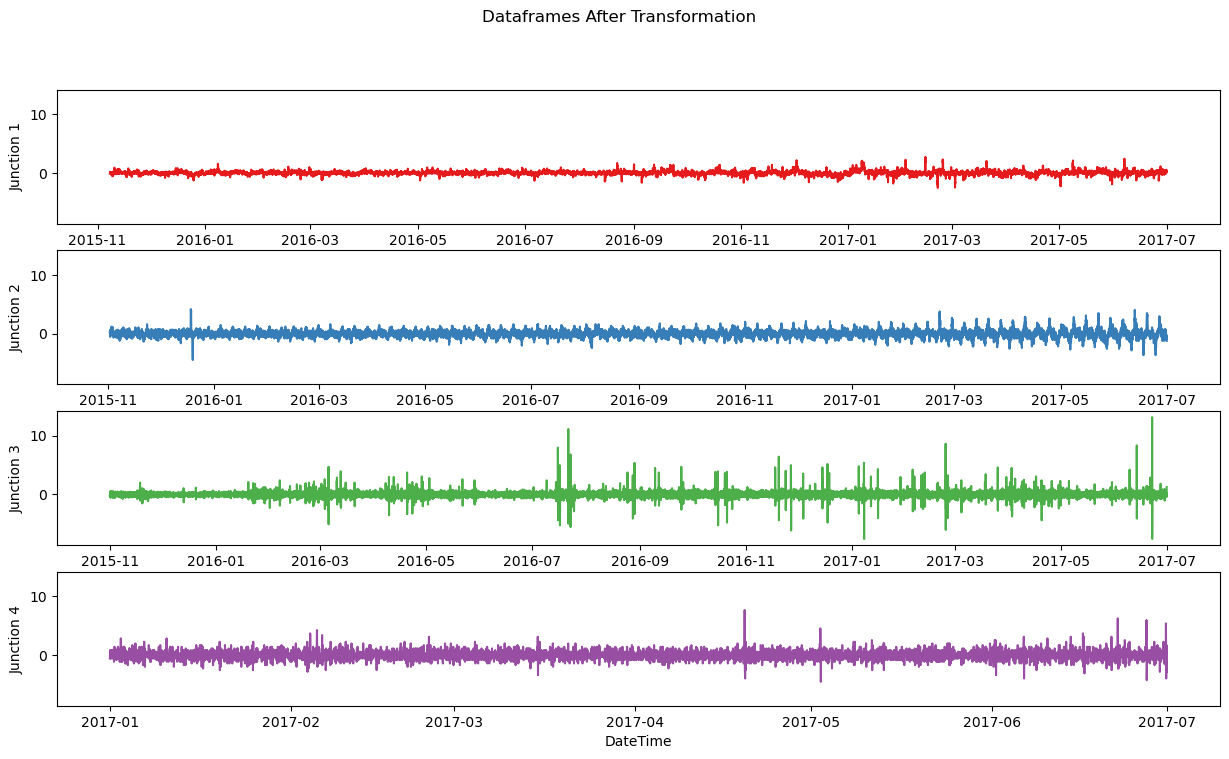

In [94]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

**Now that the data is stationary,  preprocessing the data for the neural net by:**

* Splitting the test train sets
* Assigning X as features and y as target 
* Reshaping data for neural net

In [96]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

## 6. Model Building


In [101]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

#GRU Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

# MLP Model for the prediction
def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
    X_Test = np.squeeze(X_Test)    # Do the same for the test data
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    model = Sequential()
    model.add(Dense(150, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_testJ1, y_testJ1), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("Root mean squared error = {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

## 7. Fitting The Model

In [99]:
#Predictions For First Junction

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ1_GRU = GRU_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ1_MLP = MLP_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)


########------GRU Model------########
Epoch 1/50
108/108 [==============================] - 39s 253ms/step - loss: 0.0759 - val_loss: 0.0935
Epoch 2/50
108/108 [==============================] - 25s 229ms/step - loss: 0.0654 - val_loss: 0.0889
Epoch 3/50
108/108 [==============================] - 25s 230ms/step - loss: 0.0643 - val_loss: 0.0889
Epoch 4/50
108/108 [==============================] - 26s 237ms/step - loss: 0.0620 - val_loss: 0.0826
Epoch 5/50
108/108 [==============================] - 25s 228ms/step - loss: 0.0606 - val_loss: 0.0792
Epoch 6/50
108/108 [==============================] - 25s 230ms/step - loss: 0.0592 - val_loss: 0.0769
Epoch 7/50
108/108 [==============================] - 24s 225ms/step - loss: 0.0580 - val_loss: 0.0746
Epoch 8/50
108/108 [==============================] - 25s 229ms/step - loss: 0.0573 - val_loss: 0.0730
Epoch 9/50
108/108 [==============================] - 25s 228ms/step - loss: 0.0563 - val_loss: 0.0721
Epoch 10/50
108/108 [==============

########------GRU Model------########
Root mean squared error = 0.24773361126524054.


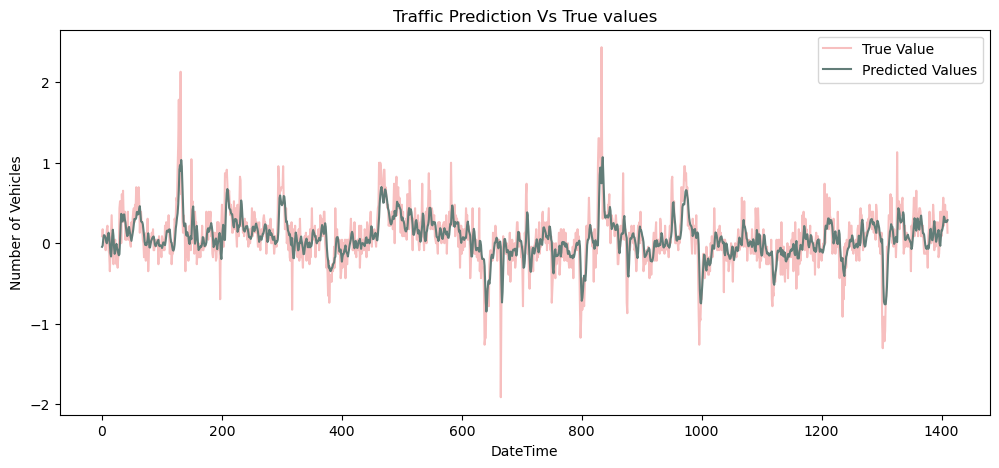


########------MLP Model------########
Root mean squared error = 0.24452662948209752.


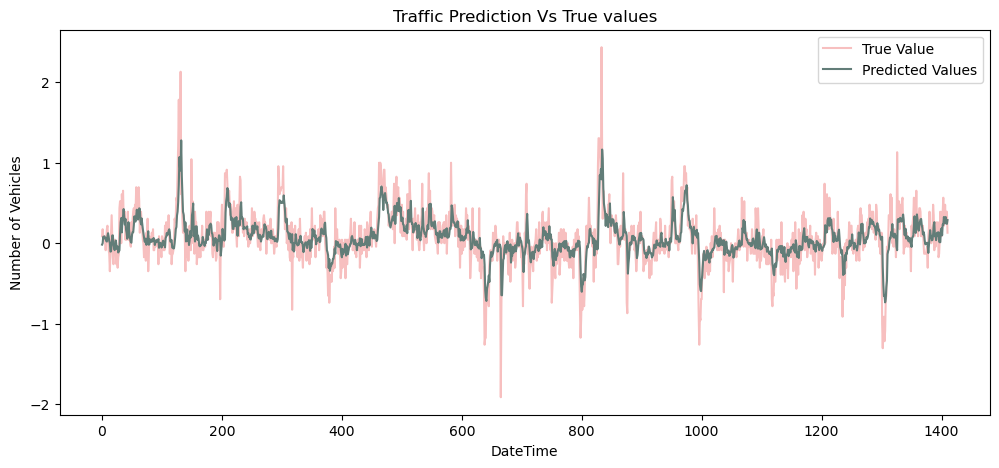

,MODEL,RMSE
0,GRU,0.247734
1,MLP,0.244527


In [180]:
# Results for J1 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J1_GRU = RMSE_Value(y_testJ1, PredJ1_GRU)
PredictionsPlot(y_testJ1, PredJ1_GRU, 0)

# Results for J1 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J1_MLP = RMSE_Value(y_testJ1, PredJ1_MLP)
PredictionsPlot(y_testJ1, PredJ1_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["GRU", "MLP"]
rmse_values = [RMSE_J1_GRU, RMSE_J1_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_1_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_1_df.style.background_gradient(cmap="YlOrRd")   

display(styled_df)

In [173]:
# Predictions For Second Junction

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ2_GRU = GRU_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ2_MLP = MLP_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

########------GRU Model------########
Epoch 1/50
109/109 [==============================] - 51s 304ms/step - loss: 0.2624 - val_loss: 0.5386
Epoch 2/50
109/109 [==============================] - 30s 276ms/step - loss: 0.2197 - val_loss: 0.4743
Epoch 3/50
109/109 [==============================] - 30s 278ms/step - loss: 0.2116 - val_loss: 0.4209
Epoch 4/50
109/109 [==============================] - 30s 274ms/step - loss: 0.2071 - val_loss: 0.4118
Epoch 5/50
109/109 [==============================] - 31s 282ms/step - loss: 0.2053 - val_loss: 0.4068
Epoch 6/50
109/109 [==============================] - 31s 280ms/step - loss: 0.2027 - val_loss: 0.3842
Epoch 7/50
109/109 [==============================] - 32s 290ms/step - loss: 0.1983 - val_loss: 0.3651
Epoch 8/50
109/109 [==============================] - 32s 292ms/step - loss: 0.2001 - val_loss: 0.3826
Epoch 9/50
109/109 [==============================] - 32s 291ms/step - loss: 0.1994 - val_loss: 0.3666
Epoch 10/50
109/109 [==============

########------GRU Model------########
Root mean squared error = 0.5643935648820875.


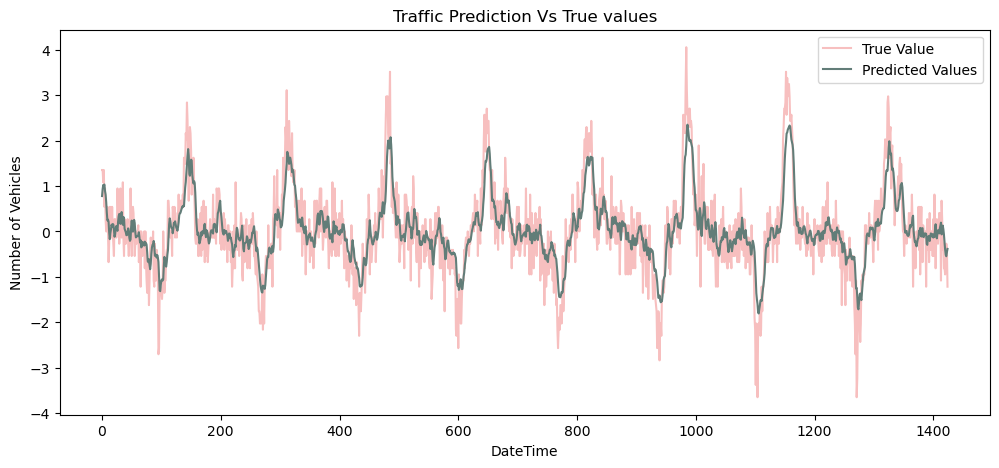


########------MLP Model------########
Root mean squared error = 0.5224905086562588.


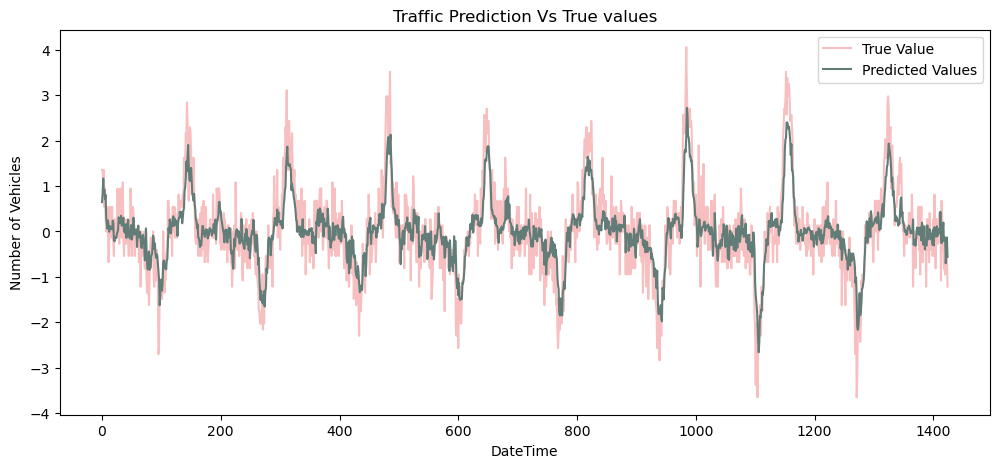

,MODEL,RMSE
0,GRU,0.564394
1,MLP,0.522491


In [174]:
# Results for J2 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J2_GRU = RMSE_Value(y_testJ2, PredJ2_GRU)
PredictionsPlot(y_testJ2, PredJ2_GRU, 0)

# Results for J2 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J2_MLP = RMSE_Value(y_testJ2, PredJ2_MLP)
PredictionsPlot(y_testJ2, PredJ2_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["GRU", "MLP"]
rmse_values = [RMSE_J2_GRU, RMSE_J2_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_2_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_2_df.style.background_gradient(cmap="YlOrRd")   

display(styled_df)

In [175]:
# Predictions For Third Junction

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ3_GRU = GRU_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ3_MLP = MLP_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

########------GRU Model------########
Epoch 1/50
110/110 [==============================] - 47s 297ms/step - loss: 0.3033 - val_loss: 0.4031
Epoch 2/50
110/110 [==============================] - 32s 289ms/step - loss: 0.3008 - val_loss: 0.4084
Epoch 3/50
110/110 [==============================] - 31s 285ms/step - loss: 0.2939 - val_loss: 0.3982
Epoch 4/50
110/110 [==============================] - 32s 288ms/step - loss: 0.2929 - val_loss: 0.3906
Epoch 5/50
110/110 [==============================] - 32s 294ms/step - loss: 0.2912 - val_loss: 0.3903
Epoch 6/50
110/110 [==============================] - 32s 289ms/step - loss: 0.2929 - val_loss: 0.3893
Epoch 7/50
110/110 [==============================] - 31s 284ms/step - loss: 0.2913 - val_loss: 0.3900
Epoch 8/50
110/110 [==============================] - 32s 293ms/step - loss: 0.2906 - val_loss: 0.3899
Epoch 9/50
110/110 [==============================] - 33s 297ms/step - loss: 0.2881 - val_loss: 0.3876
Epoch 10/50
110/110 [==============

########------GRU Model------########
Root mean squared error = 0.6157057806563813.


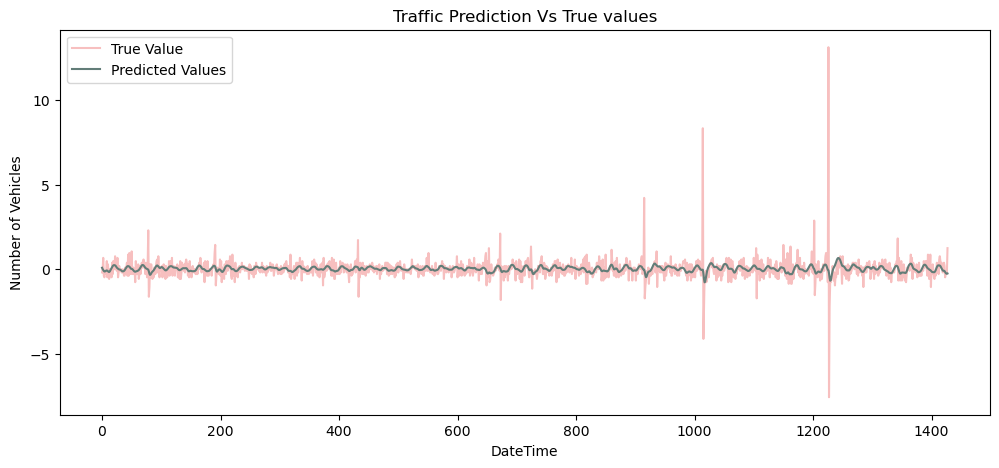


########------MLP Model------########
Root mean squared error = 0.6196223492929742.


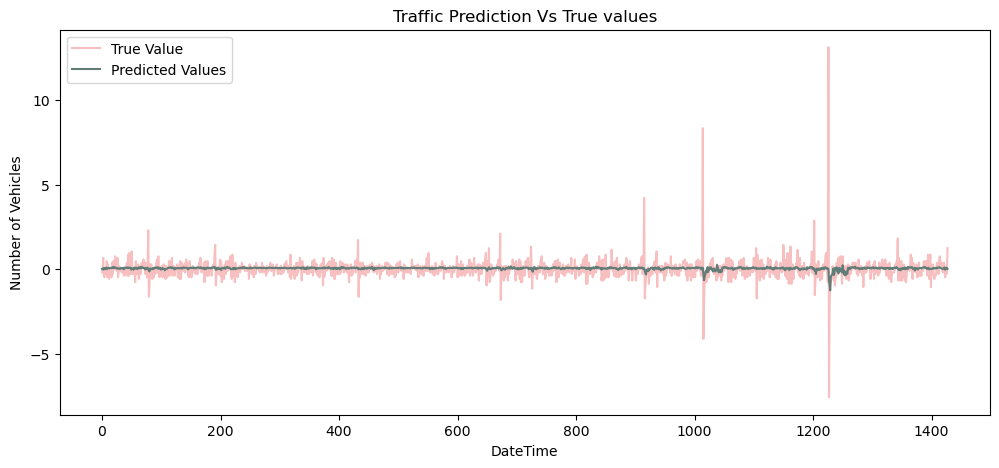

,MODEL,RMSE
0,GRU,0.615706
1,MLP,0.619622


In [176]:
# Results for J3 - Custom Model

# Results for J3 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J3_GRU = RMSE_Value(y_testJ3, PredJ3_GRU)
PredictionsPlot(y_testJ3, PredJ3_GRU, 0)

# Results for J3 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J3_MLP = RMSE_Value(y_testJ3, PredJ3_MLP)
PredictionsPlot(y_testJ3, PredJ3_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["GRU", "MLP"]
rmse_values = [RMSE_J3_GRU, RMSE_J3_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_3_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_3_df.style.background_gradient(cmap="YlOrRd")   

display(styled_df)

In [177]:
# Predictions For Fourth Junction
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ4_GRU = GRU_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ4_MLP = MLP_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)

########------GRU Model------########
Epoch 1/50
33/33 [==============================] - 72s 821ms/step - loss: 0.6930 - val_loss: 1.2529
Epoch 2/50
33/33 [==============================] - 24s 724ms/step - loss: 0.6901 - val_loss: 1.2425
Epoch 3/50
33/33 [==============================] - 23s 707ms/step - loss: 0.6896 - val_loss: 1.2477
Epoch 4/50
33/33 [==============================] - 23s 707ms/step - loss: 0.6907 - val_loss: 1.2406
Epoch 5/50
33/33 [==============================] - 24s 732ms/step - loss: 0.6904 - val_loss: 1.2341
Epoch 6/50
33/33 [==============================] - 24s 718ms/step - loss: 0.6855 - val_loss: 1.2332
Epoch 7/50
33/33 [==============================] - 24s 720ms/step - loss: 0.6871 - val_loss: 1.2222
Epoch 8/50
33/33 [==============================] - 24s 712ms/step - loss: 0.6805 - val_loss: 1.2157
Epoch 9/50
33/33 [==============================] - 24s 711ms/step - loss: 0.6862 - val_loss: 1.2221
Epoch 10/50
33/33 [==============================] - 

########------GRU Model------########
Root mean squared error = 1.1009660066619245.


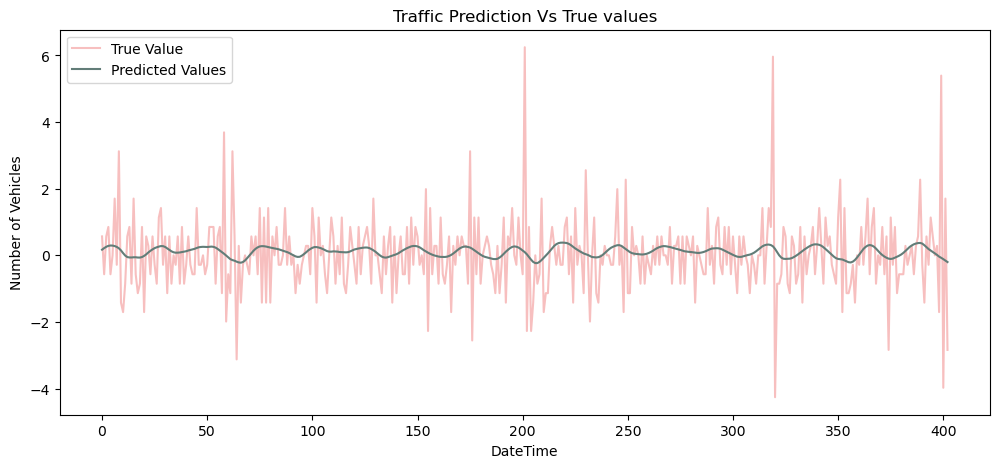


########------MLP Model------########
Root mean squared error = 1.0979376739232238.


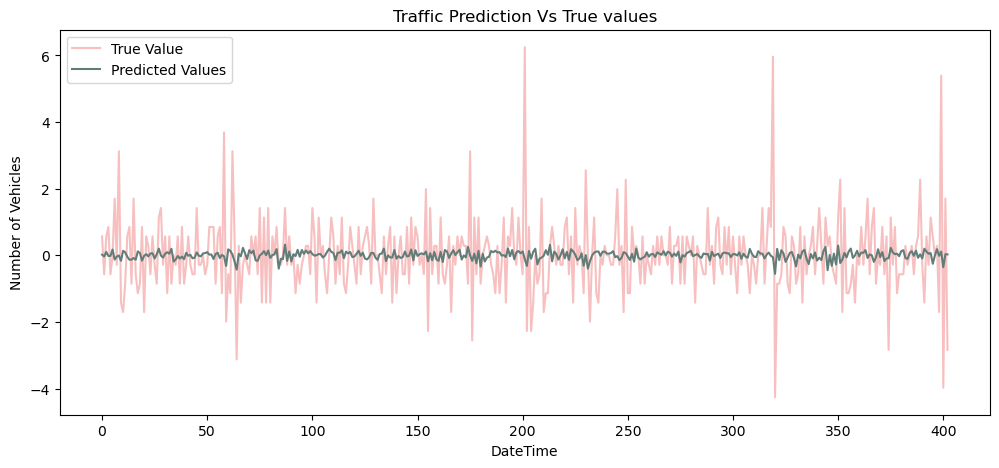

,MODEL,RMSE
0,GRU,1.100966
1,MLP,1.097938


In [178]:
# Results for J4 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J4_GRU = RMSE_Value(y_testJ4, PredJ4_GRU)
PredictionsPlot(y_testJ4, PredJ4_GRU, 0)

# Results for J4 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J4_MLP = RMSE_Value(y_testJ4, PredJ4_MLP)
PredictionsPlot(y_testJ4, PredJ4_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["GRU", "MLP"]
rmse_values = [RMSE_J4_GRU, RMSE_J4_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_4_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_4_df.style.background_gradient(cmap="YlOrRd")   

display(styled_df)

  MODEL      RMSE   JUNCTION
1   MLP  0.244527  Junction1
3   MLP  0.522491  Junction2
4   GRU  0.615706  Junction3
7   MLP  1.097938  Junction4


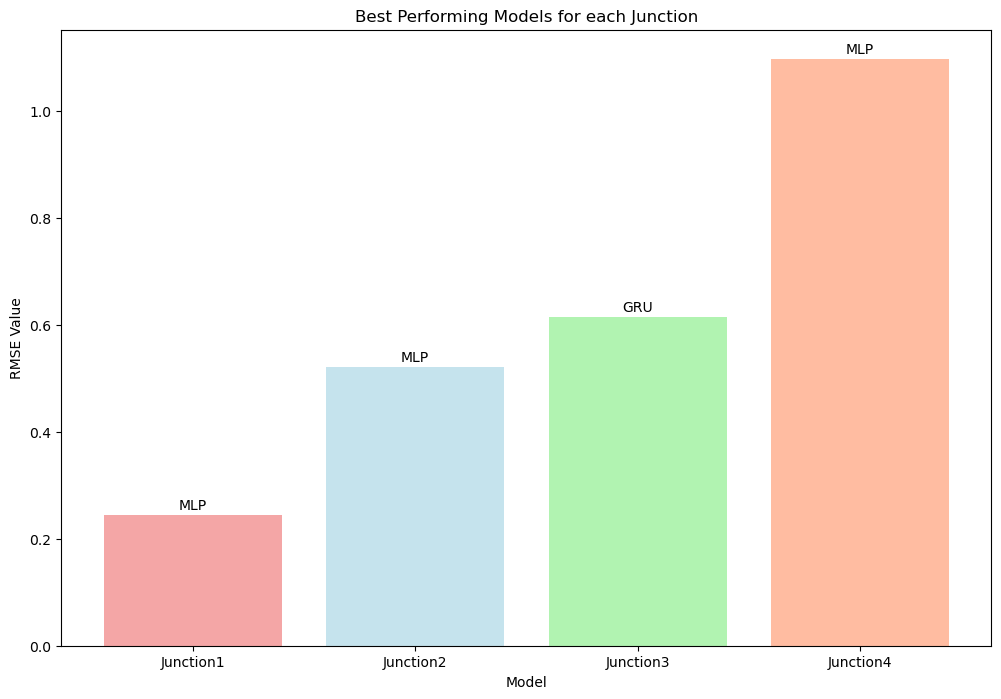

In [182]:
Results_1_df["JUNCTION"] = ['Junction1', 'Junction1']
Results_2_df["JUNCTION"] = ['Junction2', 'Junction2']
Results_3_df["JUNCTION"] = ['Junction3', 'Junction3']
Results_4_df["JUNCTION"] = ['Junction4', 'Junction4']

combined_df = pd.concat([Results_1_df, Results_2_df, Results_3_df, Results_4_df], ignore_index=True)

# Find the row with the minimum RMSE for each model
min_error_rows = combined_df.groupby('JUNCTION')['RMSE'].idxmin()

# Select the rows with minimum RMSE for each model
min_error_df = combined_df.loc[min_error_rows]

print(min_error_df)

colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
bars = ax.bar(min_error_df["JUNCTION"], min_error_df["RMSE"], color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('Best Performing Models for each Junction')

for bar, model_name in zip(bars, min_error_df["MODEL"]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, model_name, ha='center')

plt.show()

## 8. Summary

*In this project, we employed two different neural network architectures, namely the Gated Recurrent Unit (GRU) and the Multi-Layer Perceptron (MLP), to predict traffic patterns at four distinct junctions. Our evaluation of these models, as depicted in the graphical results, provides insights into their respective performance for traffic flow prediction.

Remarkably, in three out of the four instances, the MLP model emerged as the standout choice, owing to its remarkable predictive capabilities despite its increased complexity. However, it is worth noting that the GRU model held its own quite admirably, lagging behind the MLP only by a modest margin. Intriguingly, the GRU model even outperformed the MLP in one specific scenario – namely, predicting traffic at Junction 3.

While assessing the Root Mean Square Error (RMSE) values, it becomes evident that the GRU model, although not consistently superior, remained competitive and demonstrated its effectiveness. Notably, it surpassed the MLP in the case of Junction 3.

It's important to acknowledge that the quantity of data available played a crucial role in determining prediction accuracy. Notably, Junction 4 exhibited the highest error value, indicating that the model's performance may have been hindered by data limitations in this particular junction's context.